In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import math
from collections import defaultdict

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'
sc._settings.ScanpyConfig.figdir=Path(path_fig)

In [4]:
adata=sc.read(path_data+'data_integrated_analysed.h5ad')

## Get and unify previous annotation
Annotation from previous studies and manual mapping to unified set of names.

In [65]:
# Object for storing anno
anno_combined=[]
anno_original=[]

### STZ

In [66]:
# STZ
adata_preannotated=sc.read("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/subarna_study/GSE128565_adata_processed.h5ad.h5",
                          backed='r')

In [67]:
# Rename preannotated dataset obs and order it to match current dataset
preannotated_obs=adata_preannotated.obs.copy()
preannotated_obs.index=[idx.replace('_','-')+'-STZ' for idx in preannotated_obs.index]

In [68]:
# Columns in obs
preannotated_obs.columns.to_list()

['percent_mito',
 'percent_ribo',
 'n_counts',
 'n_genes',
 'groups',
 'treatment',
 'groups_named_broad',
 'S_score',
 'G2M_score',
 'phase',
 'proliferation',
 'proliferation_man',
 'doublet_score',
 'groups_named_fine',
 'groups_named_beta_dpt',
 'Ins-Gcg-Sst',
 'groups_named_broad_cond']

In [69]:
# Cell type annotations
for annotation in ['groups_named_broad','groups_named_fine', 
                   'groups_named_beta_dpt']:
    print(annotation)
    display(preannotated_obs[annotation].value_counts(dropna=False))

groups_named_broad


beta            12414
polyhormonal     6541
delta            6172
alpha            5990
PP               1771
Name: groups_named_broad, dtype: int64

groups_named_fine


Sst-Ppy_low             6172
Gcg                     5990
Ins_1                   5716
Ins_dedifferentiated    4150
Ins-Sst-Ppy             3080
Ins_2                   2548
Ins-Ppy                 1829
Ppy                     1771
Gcg-Ppy_high             880
Gcg-Ppy_low              629
Ins-Sst                  123
Name: groups_named_fine, dtype: int64

groups_named_beta_dpt


Sst-Ppy_low             6172
Gcg                     5990
Ins_1                   5506
Ins_dedifferentiated    4150
Ins-Sst-Ppy             3080
Ins_2                   2548
Ins-Ppy                 1829
Ppy                     1771
Gcg-Ppy_high             880
Gcg-Ppy_low              629
Ins_3                    210
Ins-Sst                  123
Name: groups_named_beta_dpt, dtype: int64

In [70]:
# Compare broad and fine annotation
pd.crosstab(preannotated_obs['groups_named_broad'],preannotated_obs['groups_named_fine'],
           dropna=False)

groups_named_fine,Ins_1,Ins_2,Ins_dedifferentiated,Ins-Ppy,Ins-Sst,Ins-Sst-Ppy,Gcg,Gcg-Ppy_low,Gcg-Ppy_high,Ppy,Sst-Ppy_low
groups_named_broad,,,,,,,,,,,
beta,5716,2548,4150,0,0,0,0,0,0,0,0
alpha,0,0,0,0,0,0,5990,0,0,0,0
delta,0,0,0,0,0,0,0,0,0,0,6172
PP,0,0,0,0,0,0,0,0,0,1771,0
polyhormonal,0,0,0,1829,123,3080,0,629,880,0,0


In [71]:
# Remap annotation
anno_map={'Ins_1':'beta',
          'Ins_2':'beta',
          'Ins_dedifferentiated':'beta',
          'Ins-Ppy':'beta_gamma',
          'Ins-Sst':'beta_delta',
          'Ins-Sst-Ppy':'beta_delta_gamma',
          'Gcg':'alpha',
          'Gcg-Ppy_low':'alpha_gamma',
          'Gcg-Ppy_high':'alpha_gamma',
          'Ppy':'gamma',
          'Sst-Ppy_low':'delta'}

C: Annotation is hard to remap here to my annotation as polyhormonal cells are annotated with hormones rather than cell types (as in my data).

In [72]:
# Save anno
anno_combined.append(preannotated_obs['groups_named_fine'].map(anno_map))
anno_original.append(preannotated_obs['groups_named_fine'])

### Fltp_P16

In [73]:
# Fltp_P16 data - 2 adatas were in GEO
adata_preannotated=sc.read("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/preannotated/GSE161966_data_annotated.h5ad",
                           backed='r')
adata_preannotated2=sc.read("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/preannotated/GSE161966_data_endo_final.h5ad",
                           backed='r')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [74]:
# Rename preannotated dataset obs and order it to match current dataset
# Merge both obs and rename them
obs1=adata_preannotated.obs.copy()
obs1.columns=[c+'_1' for c in obs1.columns]
obs2=adata_preannotated2.obs.copy()
obs2.columns=[c+'_2' for c in obs2.columns]
preannotated_obs=pd.concat([obs1,obs2],axis=1)
cell_name_map={'-mGFP':'-145_mGFP','-mRFP':'-146_mRFP','-mTmG':'-147_mTmG'}
preannotated_obs.index=[h.replace_all(cell,cell_name_map)+'-Fltp_P16' 
                        for cell in preannotated_obs.index]

In [75]:
# Columns in obs
preannotated_obs.columns.to_list()

['sample_1',
 'eGFP_plus_1',
 'eGFP_minus_1',
 'Td-Tomato-plus_1',
 'Td-Tomato-minus_1',
 'n_counts_1',
 'log_counts_1',
 'n_genes_1',
 'mt_fraction_1',
 'doublet_score_1',
 'doublet_1',
 'S_score_1',
 'G2M_score_1',
 'phase_1',
 'x_score_1',
 'y_score_1',
 'sex_1',
 'louvain_1',
 'cell_type_1',
 'sample_2',
 'eGFP_plus_2',
 'eGFP_minus_2',
 'Td-Tomato-plus_2',
 'Td-Tomato-minus_2',
 'n_counts_2',
 'log_counts_2',
 'n_genes_2',
 'mt_fraction_2',
 'doublet_score_2',
 'doublet_2',
 'S_score_2',
 'G2M_score_2',
 'phase_2',
 'x_score_2',
 'y_score_2',
 'sex_2',
 'louvain_2',
 'cell_type_2',
 'louvain_R_2',
 'louvain_no_sex_2',
 'cell_type_refined_2']

In [76]:
# Cell type annotations
for annotation in ['cell_type_1','cell_type_2','louvain_R_2','cell_type_refined_2']:
    print(annotation)
    display(preannotated_obs[annotation].value_counts(dropna=False))

cell_type_1


alpha                   7604
beta                    7275
delta                   1687
gamma                    684
stellate                 554
alpha-delta              531
beta-delta               330
endothelial              241
alpha, proliferating     214
acinar/ductal            144
beta, proliferating      114
alpha-beta               100
gamma, proliferating      95
immune                    93
delta, proliferating      66
epsilon                   16
Name: cell_type_1, dtype: int64

cell_type_2


alpha      7604
beta       7275
delta      1687
poly       1450
NaN        1032
gamma       684
epsilon      16
Name: cell_type_2, dtype: int64

louvain_R_2


alpha      7604
beta       7275
delta      1687
NaN        1032
gamma       684
poly,0      214
poly,1      182
poly,2      180
poly,3      175
poly,4      169
poly,5      155
poly,6      114
poly,7      100
poly,8       95
poly,9       66
epsilon      16
Name: louvain_R_2, dtype: int64

cell_type_refined_2


alpha                   7604
beta                    7275
delta                   1687
NaN                     1032
gamma                    684
alpha-delta              351
beta-delta               330
alpha, proliferating     214
poly                     180
beta, proliferating      114
alpha-beta               100
gamma, proliferating      95
delta, proliferating      66
epsilon                   16
Name: cell_type_refined_2, dtype: int64

In [77]:
# Compare annotations from the two adata objects
pd.crosstab(preannotated_obs['cell_type_1'],preannotated_obs['cell_type_refined_2'],
           dropna=False)

cell_type_refined_2,alpha,beta,gamma,delta,poly,epsilon,alpha-delta,beta-delta,alpha-beta,"alpha, proliferating","beta, proliferating","gamma, proliferating","delta, proliferating"
cell_type_1,,,,,,,,,,,,,
alpha,7604,0,0,0,0,0,0,0,0,0,0,0,0
beta,0,7275,0,0,0,0,0,0,0,0,0,0,0
gamma,0,0,684,0,0,0,0,0,0,0,0,0,0
delta,0,0,0,1687,0,0,0,0,0,0,0,0,0
stellate,0,0,0,0,0,0,0,0,0,0,0,0,0
endothelial,0,0,0,0,0,0,0,0,0,0,0,0,0
acinar/ductal,0,0,0,0,0,0,0,0,0,0,0,0,0
immune,0,0,0,0,0,0,0,0,0,0,0,0,0
epsilon,0,0,0,0,0,16,0,0,0,0,0,0,0


In [78]:
# Remap annotation
anno_map={'alpha':'alpha',
 'beta':'beta',
 'beta-delta':'beta_delta',
 'alpha-delta':'alpha_delta',
 'gamma, proliferating':'gamma proliferative',
 'delta':'delta',
 'stellate':'stellate',
 'delta, proliferating':'delta proliferaive',
 'alpha, proliferating':'alpha proliferative',
 'beta, proliferating':'beta proliferative',
 'acinar/ductal':'acinar/ductal',
 'gamma':'gamma',
 'alpha-beta':'alpha_beta',
 'epsilon':'epsilon',
 'immune':'immune',
 'endothelial':'endothelial'}

In [79]:
# Save anno
anno_combined.append(preannotated_obs['cell_type_1'].map(anno_map))
anno_original.append(preannotated_obs['cell_type_1'])

### Spikein_drug

In [80]:
# Spikein drug
preannotated_obs=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/preannotated/GSE142465_MouseLTI_CellAnnotation_final.tsv',
                                 index_col=0)

In [81]:
# Rename preannotated dataset obs and order it to match current dataset
sample_dict=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='spikein_drug',index_col='metadata')['sample_name'].to_dict()
preannotated_obs.index=[idx.split('-')[0]+'-1-'+\
                        sample_dict[preannotated_obs.at[idx,'sample']] +\
                        '-spikein_drug'
                        for idx in preannotated_obs.index]

In [82]:
# Columns in obs
preannotated_obs.columns.to_list()

['nGene',
 'nUMI',
 'orig.ident',
 'sample',
 'percent.mito',
 'res.0.5',
 'ClusterNames_0.5',
 'tSNE_1',
 'tSNE_2',
 'celltype',
 'spikeIn',
 'replicate',
 'treatment',
 'PredictedCell',
 'PredictionConf',
 'PredictionMax',
 'celltype2',
 'nGene.peak',
 'nGene.doublet',
 'Ins2',
 'Gcg']

In [83]:
# Cell type annotations
for annotation in ['celltype','celltype2','PredictedCell']:
    print(annotation)
    display(preannotated_obs[annotation].value_counts(dropna=False))

celltype


Beta            15122
3                3608
Alpha            3463
4                3380
Endocrine        2821
Gamma            1472
SI_Human         1093
Acinar            801
Endothelial1      790
10                775
Delta             636
11                356
Endothelial2      353
13                336
SI_Mouse          327
Name: celltype, dtype: int64

celltype2


Beta            16415
Alpha            3934
3                3608
4                3380
Gamma            2287
SI_Human         1093
Acinar            854
Delta             796
Endothelial1      790
10                775
11                385
Endothelial2      353
13                336
SI_Mouse          327
Name: celltype2, dtype: int64

PredictedCell


Beta      19342
Alpha      4796
Delta      3471
Gamma      2894
Acinar     2802
11         2028
Name: PredictedCell, dtype: int64

In [84]:
# Compare broad and fine annotation
pd.crosstab(preannotated_obs['celltype'],preannotated_obs['celltype2'],
           dropna=False)

celltype2,10,11,13,3,4,Acinar,Alpha,Beta,Delta,Endothelial1,Endothelial2,Gamma,SI_Human,SI_Mouse
celltype,,,,,,,,,,,,,,
10,775,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,356,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,336,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,3608,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,3380,0,0,0,0,0,0,0,0,0
Acinar,0,0,0,0,0,801,0,0,0,0,0,0,0,0
Alpha,0,0,0,0,0,0,3463,0,0,0,0,0,0,0
Beta,0,0,0,0,0,0,0,15122,0,0,0,0,0,0
Delta,0,0,0,0,0,0,0,0,636,0,0,0,0,0


C: They first annotated cells, then did prediction to re-annotate hard to annotate cells, and then re-annotated "endocrine" manually annotated cells to specific endocrine cell type based on the prediction. So the right annotation here is celltype2.

In [85]:
# Remap annotation
anno_map={'Beta':'beta',
 'Alpha':'alpha',
 'Acinar':'acinar',
 'Delta':'delta',
 'Gamma':'gamma',
 'Endothelial1':'endothelial',
 '3':'unknown',
 'Endothelial2':'endothelial',
 '4':'unknown',
 '10':'unknown',
 'SI_Human':'spikein_human',
 'SI_Mouse':'spikein_mouse',
 '13':'unknown',
 '11':'unknown'}

In [86]:
# Save anno
anno_combined.append(preannotated_obs['celltype2'].map(anno_map))
anno_original.append(preannotated_obs['celltype2'])

### Embryo

In [87]:
# Embryo
adata_preannotated=sc.read("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE132188/rev7/preannotated/GSE132188_adata.h5ad.h5",
                          backed='r')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [88]:
# Rename preannotated dataset obs and order it to match current dataset
preannotated_obs=adata_preannotated.obs.copy()
preannotated_obs.index=['-'.join(idx.split('-')[:-1])+\
                        '-E'+preannotated_obs.at[idx,'day'].replace('.','_')+\
                        '-embryo' for idx in preannotated_obs.index]

In [89]:
# Columns in obs
preannotated_obs.columns.to_list()

['day',
 'n_counts',
 'log_counts',
 'n_genes',
 'mt_frac',
 'proliferation',
 'G2M_score',
 'S_score',
 'clusters_fig3_final',
 'clusters_fig3_final_noep',
 'clusters_fig4_final',
 'clusters_fig2_final',
 'clusters_fig6_broad_final',
 'clusters_fig6_fine_final',
 'clusters_fig6_alpha_final']

In [90]:
# Cell type annotations
for annotation in [ 
     'clusters_fig3_final',
     'clusters_fig3_final_noep',
     'clusters_fig4_final',
     'clusters_fig2_final',
     'clusters_fig6_broad_final',
     'clusters_fig6_fine_final',
     'clusters_fig6_alpha_final']:
    print(annotation)
    display(preannotated_obs[annotation].value_counts(dropna=False))

clusters_fig3_final


Mat. Acinar      7067
Ductal           4268
Tip              3821
Prlf. Acinar     3365
Endocrine        2999
Ngn3 low EP      2616
Ngn3 high EP     2503
Prlf. Ductal     2307
Prlf. Tip        2284
Fev+             2058
Multipotent      1225
Prlf. Trunk      1205
Trunk             633
Other/Doublet       0
Name: clusters_fig3_final, dtype: int64

clusters_fig3_final_noep


Mat. Acinar      7067
Ductal           5755
Tip              3999
Prlf. Acinar     3365
Endocrine        2999
Prlf. Ductal     2959
Ngn3 high EP     2503
Prlf. Tip        2421
Fev+             2058
Prlf. Trunk      1254
Multipotent      1244
Trunk             727
Other/Doublet       0
Name: clusters_fig3_final_noep, dtype: int64

clusters_fig4_final


Excluded           22599
Ductal Bipotent     6575
Ngn3 low EP         2616
Ngn3 high EP        2503
Fev+                2058
Name: clusters_fig4_final, dtype: int64

clusters_fig2_final


Acinar           10432
Ductal            6575
Tip               6105
EP                5119
Endocrine         2999
Fev+              2058
Trunk             1838
Multipotent       1225
Other/Doublet        0
Name: clusters_fig2_final, dtype: int64

clusters_fig6_broad_final


Mat. Acinar      7067
Ductal           4268
Tip              3821
Prlf. Acinar     3365
Ngn3 low EP      2616
Ngn3 high EP     2503
Prlf. Ductal     2307
Prlf. Tip        2284
Fev+             2058
Alpha            1428
Beta             1237
Multipotent      1225
Prlf. Trunk      1205
Trunk             633
Epsilon           231
Delta             103
Other/Doublet       0
Name: clusters_fig6_broad_final, dtype: int64

clusters_fig6_fine_final


Acinar             10432
Ductal              6575
Tip                 6105
Ngn3 low EP         2616
Trunk               1838
Ngn3 High late      1732
Alpha               1428
Fev+ Beta           1359
Beta                1237
Multipotent         1225
Ngn3 High early      771
Fev+ Alpha           345
Epsilon              231
Fev+ Pyy             132
Fev+ Epsilon         112
Fev+ Delta           110
Delta                103
Other/Doublet          0
Name: clusters_fig6_fine_final, dtype: int64

clusters_fig6_alpha_final


NaN                10432
Ductal              6575
Tip                 6105
Ngn3 low EP         2616
Trunk               1838
Ngn3 High late      1732
Fev+ Beta           1359
Beta                1237
Multipotent         1225
secondary Alpha     1160
Ngn3 High early      771
Fev+ Alpha           345
primary Alpha        268
Epsilon              231
Fev+ Pyy             132
Fev+ Epsilon         112
Fev+ Delta           110
Delta                103
Mat. Acinar            0
Prlf. Acinar           0
Other/Doublet          0
Name: clusters_fig6_alpha_final, dtype: int64

In [91]:
# Compare broad and fine annotation
pd.crosstab(preannotated_obs['clusters_fig3_final'],preannotated_obs['clusters_fig6_broad_final'],
           dropna=False)

clusters_fig6_broad_final,Multipotent,Tip,Prlf. Tip,Prlf. Acinar,Mat. Acinar,Trunk,Prlf. Trunk,Ductal,Prlf. Ductal,Ngn3 low EP,Ngn3 high EP,Fev+,Beta,Alpha,Delta,Epsilon,Other/Doublet
clusters_fig3_final,,,,,,,,,,,,,,,,,
Multipotent,1225,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tip,0,3821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Prlf. Tip,0,0,2284,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Prlf. Acinar,0,0,0,3365,0,0,0,0,0,0,0,0,0,0,0,0,0
Mat. Acinar,0,0,0,0,7067,0,0,0,0,0,0,0,0,0,0,0,0
Trunk,0,0,0,0,0,633,0,0,0,0,0,0,0,0,0,0,0
Prlf. Trunk,0,0,0,0,0,0,1205,0,0,0,0,0,0,0,0,0,0
Ductal,0,0,0,0,0,0,0,4268,0,0,0,0,0,0,0,0,0
Prlf. Ductal,0,0,0,0,0,0,0,0,2307,0,0,0,0,0,0,0,0


In [92]:
# Compare broad and fine annotation
pd.crosstab(preannotated_obs['clusters_fig6_fine_final'],preannotated_obs['clusters_fig6_broad_final'],
           dropna=False)

clusters_fig6_broad_final,Multipotent,Tip,Prlf. Tip,Prlf. Acinar,Mat. Acinar,Trunk,Prlf. Trunk,Ductal,Prlf. Ductal,Ngn3 low EP,Ngn3 high EP,Fev+,Beta,Alpha,Delta,Epsilon,Other/Doublet
clusters_fig6_fine_final,,,,,,,,,,,,,,,,,
Multipotent,1225,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tip,0,3821,2284,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Acinar,0,0,0,3365,7067,0,0,0,0,0,0,0,0,0,0,0,0
Trunk,0,0,0,0,0,633,1205,0,0,0,0,0,0,0,0,0,0
Ductal,0,0,0,0,0,0,0,4268,2307,0,0,0,0,0,0,0,0
Ngn3 low EP,0,0,0,0,0,0,0,0,0,2616,0,0,0,0,0,0,0
Ngn3 High early,0,0,0,0,0,0,0,0,0,0,771,0,0,0,0,0,0
Ngn3 High late,0,0,0,0,0,0,0,0,0,0,1732,0,0,0,0,0,0
Fev+ Beta,0,0,0,0,0,0,0,0,0,0,0,1359,0,0,0,0,0


In [93]:
# Compare broad and fine annotation
pd.crosstab(preannotated_obs['clusters_fig6_alpha_final'],preannotated_obs['clusters_fig6_broad_final'],
           dropna=False)

clusters_fig6_broad_final,Multipotent,Tip,Prlf. Tip,Prlf. Acinar,Mat. Acinar,Trunk,Prlf. Trunk,Ductal,Prlf. Ductal,Ngn3 low EP,Ngn3 high EP,Fev+,Beta,Alpha,Delta,Epsilon,Other/Doublet
clusters_fig6_alpha_final,,,,,,,,,,,,,,,,,
Multipotent,1225,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tip,0,3821,2284,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Prlf. Acinar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Mat. Acinar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Trunk,0,0,0,0,0,633,1205,0,0,0,0,0,0,0,0,0,0
Ductal,0,0,0,0,0,0,0,4268,2307,0,0,0,0,0,0,0,0
Ngn3 low EP,0,0,0,0,0,0,0,0,0,2616,0,0,0,0,0,0,0
Ngn3 High early,0,0,0,0,0,0,0,0,0,0,771,0,0,0,0,0,0
Ngn3 High late,0,0,0,0,0,0,0,0,0,0,1732,0,0,0,0,0,0


C: Different annotations have different cell types resolved. 
- clusters_fig6_broad_final: general resolution
- clusters_fig6_alpha_final: resolves primary and secondary alpha cells, resolves endocrine progenitor cells
- clusters_fig6_fine_final: resolves endocrine progenitor cells
- clusters_fig3_final: From fig3 plot. But fig6 is higher resolution.

In [94]:
# Make fine cell type column from fig6 annotations
preannotated_obs['cell_type_combined']=[ct if ct not in ['Ngn3 high EP','Alpha','Fev+'] 
                                        else ct_a
                                        for ct,ct_a in zip(
                                            preannotated_obs['clusters_fig6_broad_final'],
                                            preannotated_obs['clusters_fig6_alpha_final'])]

In [95]:
# Compare broad and fine annotation
pd.crosstab(preannotated_obs['cell_type_combined'],preannotated_obs['clusters_fig6_broad_final'],
           dropna=False)

clusters_fig6_broad_final,Multipotent,Tip,Prlf. Tip,Prlf. Acinar,Mat. Acinar,Trunk,Prlf. Trunk,Ductal,Prlf. Ductal,Ngn3 low EP,Ngn3 high EP,Fev+,Beta,Alpha,Delta,Epsilon,Other/Doublet
cell_type_combined,,,,,,,,,,,,,,,,,
Beta,0,0,0,0,0,0,0,0,0,0,0,0,1237,0,0,0,0
Delta,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,0,0
Ductal,0,0,0,0,0,0,0,4268,0,0,0,0,0,0,0,0,0
Epsilon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,231,0
Fev+ Alpha,0,0,0,0,0,0,0,0,0,0,0,345,0,0,0,0,0
Fev+ Beta,0,0,0,0,0,0,0,0,0,0,0,1359,0,0,0,0,0
Fev+ Delta,0,0,0,0,0,0,0,0,0,0,0,110,0,0,0,0,0
Fev+ Epsilon,0,0,0,0,0,0,0,0,0,0,0,112,0,0,0,0,0
Fev+ Pyy,0,0,0,0,0,0,0,0,0,0,0,132,0,0,0,0,0


In [96]:
preannotated_obs['cell_type_combined'].unique().tolist()

['Trunk',
 'Tip',
 'Ngn3 low EP',
 'Prlf. Tip',
 'Prlf. Trunk',
 'Multipotent',
 'Prlf. Ductal',
 'Ductal',
 'Fev+ Alpha',
 'primary Alpha',
 'Ngn3 High early',
 'Ngn3 High late',
 'Fev+ Pyy',
 'Beta',
 'secondary Alpha',
 'Prlf. Acinar',
 'Fev+ Beta',
 'Fev+ Epsilon',
 'Delta',
 'Epsilon',
 'Fev+ Delta',
 'Mat. Acinar']

In [97]:
# Remap annotation
anno_map={
     'Trunk':'trunk',
     'Tip':'tip',
     'Ngn3 low EP':'EP_Ngn3low',
     'Prlf. Tip':'tip proliferative',
     'Prlf. Trunk':'trunk proliferative',
     'Multipotent':'multipotent',
     'Prlf. Ductal':'ductal proliferative',
     'Ductal':'ductal',
     'Fev+ Alpha':'alpha_Fev+',
     'primary Alpha':'alpha_primary',
     'Ngn3 High early':'EP_Ngn3high_early',
     'Ngn3 High late':'EP_Ngn3high_late',
     'Fev+ Pyy':'Fev+_Pyy',
     'Beta':'beta',
     'secondary Alpha':'alpha_secondary',
     'Prlf. Acinar':'acinar proliferative',
     'Fev+ Beta':'Fev+_beta',
     'Fev+ Epsilon':'Fev+_epsilon',
     'Delta':'delta',
     'Epsilon':'epsilon',
     'Fev+ Delta':'Fev+_delta',
     'Mat. Acinar':'acinar_mature'}
anno_map={ct:'embryo '+ct_new for ct,ct_new in anno_map.items()}

In [98]:
# Save anno
anno_combined.append(preannotated_obs['cell_type_combined'].map(anno_map))
anno_original.append(preannotated_obs['cell_type_combined'])

### VSG

In [99]:
# VSG
adata_preannotated=sc.read("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/preannotated/adata_annotated_Lickert_10x_dbdb_VSG_2021.h5ad",
                          backed='r')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [100]:
# Rename preannotated dataset obs and order it to match current dataset
preannotated_obs=adata_preannotated.obs.copy()
preannotated_obs.index=[idx.split('-')[0]+'-1-'+sample+'-VSG' 
                        for idx,sample in zip(preannotated_obs.index,preannotated_obs['sample'])]

In [101]:
# Columns in obs
preannotated_obs.columns.to_list()

['batch',
 'procedure',
 'sample',
 'sample_desc',
 'type',
 'n_counts',
 'log_counts',
 'n_genes',
 'mt_frac',
 'size_factors',
 'annotations',
 'annotations_broad']

In [102]:
# Cell type annotations
for annotation in ['annotations','annotations_broad']:
    print(annotation)
    display(preannotated_obs[annotation].value_counts(dropna=False))

annotations


Dedifferentiated beta    13923
Immune                   13097
Mature beta              12447
Alpha                     6301
Delta                     4289
Stellate                  3848
Polyhormonal              3810
Endothelial               3212
Ductal                    2892
Ribo_high                 2732
Extreme beta              1203
PP                        1043
Nupr1_Atf5_high            521
Acinar                     245
Mlxipl_Gipr_high           176
Immature beta              136
Proliferating beta          85
Name: annotations, dtype: int64

annotations_broad


Beta            31223
Immune          13097
Alpha            6301
Delta            4289
Stellate         3848
Polyhormonal     3810
Endothelial      3212
Ductal           2892
PP               1043
Acinar            245
Name: annotations_broad, dtype: int64

In [103]:
# Compare broad and fine annotation
pd.crosstab(preannotated_obs['annotations'],preannotated_obs['annotations_broad'],
           dropna=False)

annotations_broad,Beta,Alpha,Delta,PP,Polyhormonal,Acinar,Ductal,Endothelial,Stellate,Immune
annotations,,,,,,,,,,
Mature beta,12447,0,0,0,0,0,0,0,0,0
Immature beta,136,0,0,0,0,0,0,0,0,0
Dedifferentiated beta,13923,0,0,0,0,0,0,0,0,0
Extreme beta,1203,0,0,0,0,0,0,0,0,0
Ribo_high,2732,0,0,0,0,0,0,0,0,0
Nupr1_Atf5_high,521,0,0,0,0,0,0,0,0,0
Mlxipl_Gipr_high,176,0,0,0,0,0,0,0,0,0
Alpha,0,6301,0,0,0,0,0,0,0,0
Delta,0,0,4289,0,0,0,0,0,0,0


In [104]:
# Remap annotation
anno_map={
     'Beta':'beta',
     'Alpha':'alpha',
     'Stellate':'stellate',
     'Endothelial':'endothelial',
     'Immune':'immune',
     'Polyhormonal':'polyhormonal',
     'Delta':'delta',
     'Ductal':'ductal',
     'PP':'gamma',
     'Acinar':'acinar'}

C: Annotation is hard to remap here to my annotation as polyhormonal cells are annotated with hormones rather than cell types (as in my data).

In [105]:
# Save anno
anno_combined.append(preannotated_obs['annotations_broad'].map(anno_map))
anno_original.append(preannotated_obs['annotations_broad'])

### Add anno to adata

In [106]:
# Combine anno and add to adata
anno_combined=pd.concat(anno_combined)
adata.obs['pre_cell_type_unified']=anno_combined.reindex(
    adata.obs_names).fillna('NA').astype('category')
anno_original=pd.concat(anno_original)
adata.obs['pre_cell_type_original']=anno_original.reindex(
    adata.obs_names).fillna('NA').astype('category')

In [6]:
# Also set unknown to NA
adata.obs['pre_cell_type_unified']=adata.obs['pre_cell_type_unified'].replace({'unknown':'NA'})

#### Parse some anno

In [21]:
adata.obs['cell_type_parsed']=adata.obs['cell_type'].\
       str.replace('proliferative','prolif.').\
       str.replace('_beta','+beta').\
       str.replace('_delta','+delta').\
       str.replace('_gamma','+gamma').\
       str.replace('_',' ')
sorted(adata.obs['cell_type_parsed'].unique())

['NA',
 'NA prolif.',
 'acinar',
 'acinar low',
 'alpha',
 'alpha prolif.',
 'alpha+beta',
 'alpha+beta prolif.',
 'alpha+beta+delta',
 'alpha+beta+delta prolif.',
 'alpha+beta+delta+gamma',
 'alpha+beta+gamma',
 'alpha+delta',
 'alpha+delta prolif.',
 'alpha+delta+gamma',
 'alpha+delta+gamma prolif.',
 'alpha+gamma',
 'alpha+gamma prolif.',
 'beta',
 'beta ins low',
 'beta prolif.',
 'beta subpopulation STZref',
 'beta+delta',
 'beta+delta prolif.',
 'beta+delta+gamma',
 'beta+gamma',
 'beta+gamma prolif.',
 'delta',
 'delta prolif.',
 'delta+gamma',
 'ductal',
 'ductal prolif.',
 'endothelial',
 'endothelial pericyte',
 'epsilon',
 'gamma',
 'gamma prolif.',
 'immune',
 'pericyte',
 'schwann',
 'stellate',
 'stellate pericyte']

In [19]:
adata.obs['pre_cell_type_unified']=adata.obs['pre_cell_type_unified'].\
    str.replace('embryo','E' ).\
    str.replace('proliferative','prolif.').str.replace('proliferaive','prolif.').\
    replace({
    'alpha_beta':'alpha+beta',
    'alpha_delta':'alpha+delta',
    'alpha_gamma':'alpha+gamma',
    'beta_delta':'beta+delta',
    'beta_delta_gamma':'beta+delta+gamma',
    'beta_gamma':'beta+gamma',
    }).str.replace('_',' ')
sorted(adata.obs['pre_cell_type_unified'].unique())

['E EP Ngn3high early',
 'E EP Ngn3high late',
 'E EP Ngn3low',
 'E Fev+ Pyy',
 'E Fev+ beta',
 'E Fev+ delta',
 'E Fev+ epsilon',
 'E acinar mature',
 'E acinar prolif.',
 'E alpha Fev+',
 'E alpha primary',
 'E alpha secondary',
 'E beta',
 'E delta',
 'E ductal',
 'E ductal prolif.',
 'E epsilon',
 'E multipotent',
 'E tip',
 'E tip prolif.',
 'E trunk',
 'E trunk prolif.',
 'NA',
 'acinar',
 'acinar/ductal',
 'alpha',
 'alpha prolif.',
 'alpha+beta',
 'alpha+delta',
 'alpha+gamma',
 'beta',
 'beta prolif.',
 'beta+delta',
 'beta+delta+gamma',
 'beta+gamma',
 'delta',
 'delta prolif.',
 'ductal',
 'endothelial',
 'epsilon',
 'gamma',
 'gamma prolif.',
 'immune',
 'polyhormonal',
 'stellate']

#### Save anno

In [22]:
# Save

h.update_adata(adata_new=adata,path=path_data+'data_integrated_analysed.h5ad',
               add=[
                   ('obs',True,'cell_type_parsed','cell_type_parsed'),
                   ('obs',True,'pre_cell_type_unified','pre_cell_type_unified'),
                   ('obs',True,'pre_cell_type_original','pre_cell_type_original')
               ],
               rm=None,unique_id2=None,io_copy=False)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pre_cell_type_unified' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_parsed' as categorical


### Compare re-annotation and previous annotations

In [28]:
# Make another col without embryo for easier visualisation of other cell types
adata.obs['pre_cell_type_unified_postnatal']=adata.obs['pre_cell_type_unified'].apply(
    lambda x: 'embryo' if x.startswith('E ') else x).astype('category')

In [6]:
# Pre-set colors for main cts
adata.uns['cell_type_integrated_v2_colors']=[
   '#FFAA92', '#0AA6D8', '#FAD09F', '#72418F', '#9B9700', '#006FA6',
   '#FFB500', '#D790FF', '#FF913F', '#A4E804', '#324E72', '#D16100',
   '#44a4b8', '#B05B6F', '#A77500', '#788D66', '#BEC459', '#FF8A9A',
   '#7A87A1', '#D157A0']
ct_integr_cmap=dict(zip(adata.obs['cell_type_integrated_v2'].cat.categories,
                        adata.uns['cell_type_integrated_v2_colors']))
ct_integr_cmap={
    adata.obs.query('cell_type_integrated_v2==@ct')['cell_type_integrated_v2_parsed'][0]:c 
        for ct,c in ct_integr_cmap.items()}

In [7]:
# Custom color palete matched across columns with NA in light gary
ct_cols=['cell_type_integrated_v2_parsed',
         'pre_cell_type_unified','pre_cell_type_unified_postnatal',
         'cell_type_parsed']
for col in ct_cols:
    adata.obs[col]=adata.obs[col].astype('category')
cts_all=[ct for col in ct_cols for ct in adata.obs[col].unique().tolist()]
# Make cts unique, but so that ct integrated is first - this ensures that it gets nice colors
# For this ct integrated must also be first in cols list
# Preselect nice colors for the main figure
cts_all=[ct for idx,ct in enumerate(cts_all) if ct not in cts_all[:idx]]
colors=[ct_integr_cmap[ct] for ct in cts_all if ct in ct_integr_cmap]
colors=colors+[c for c in sc.pl.palettes.default_102 if c !='#c7c7c7' and c not in colors]
colors = dict(zip(cts_all,colors[:len(cts_all)]))
colors['NA']='#c7c7c7'
for col in ct_cols:
    adata.uns[col+'_colors']=[colors[ct] for ct in adata.obs[col].cat.categories]

In [8]:
# Custom palete for original ct - set NA to gray
cts_all=adata.obs['pre_cell_type_original'].unique().tolist()
colors=[c for c in sc.pl.palettes.default_102 if c !='#c7c7c7']
colors = dict(zip(cts_all,colors[:len(cts_all)]))
colors['NA']='#c7c7c7'
adata.uns['pre_cell_type_original_colors']=[
    colors[ct] for ct in adata.obs['pre_cell_type_original'].cat.categories]

In [10]:
# Save color palete for cts
if False:
    h.update_adata(adata_new=adata,path=path_data+'data_integrated_analysed.h5ad',
               add=[
                  ('uns',True,'cell_type_integrated_v2_colors','cell_type_integrated_v2_colors'),
               ],
               rm=None,unique_id2=None,io_copy=False)

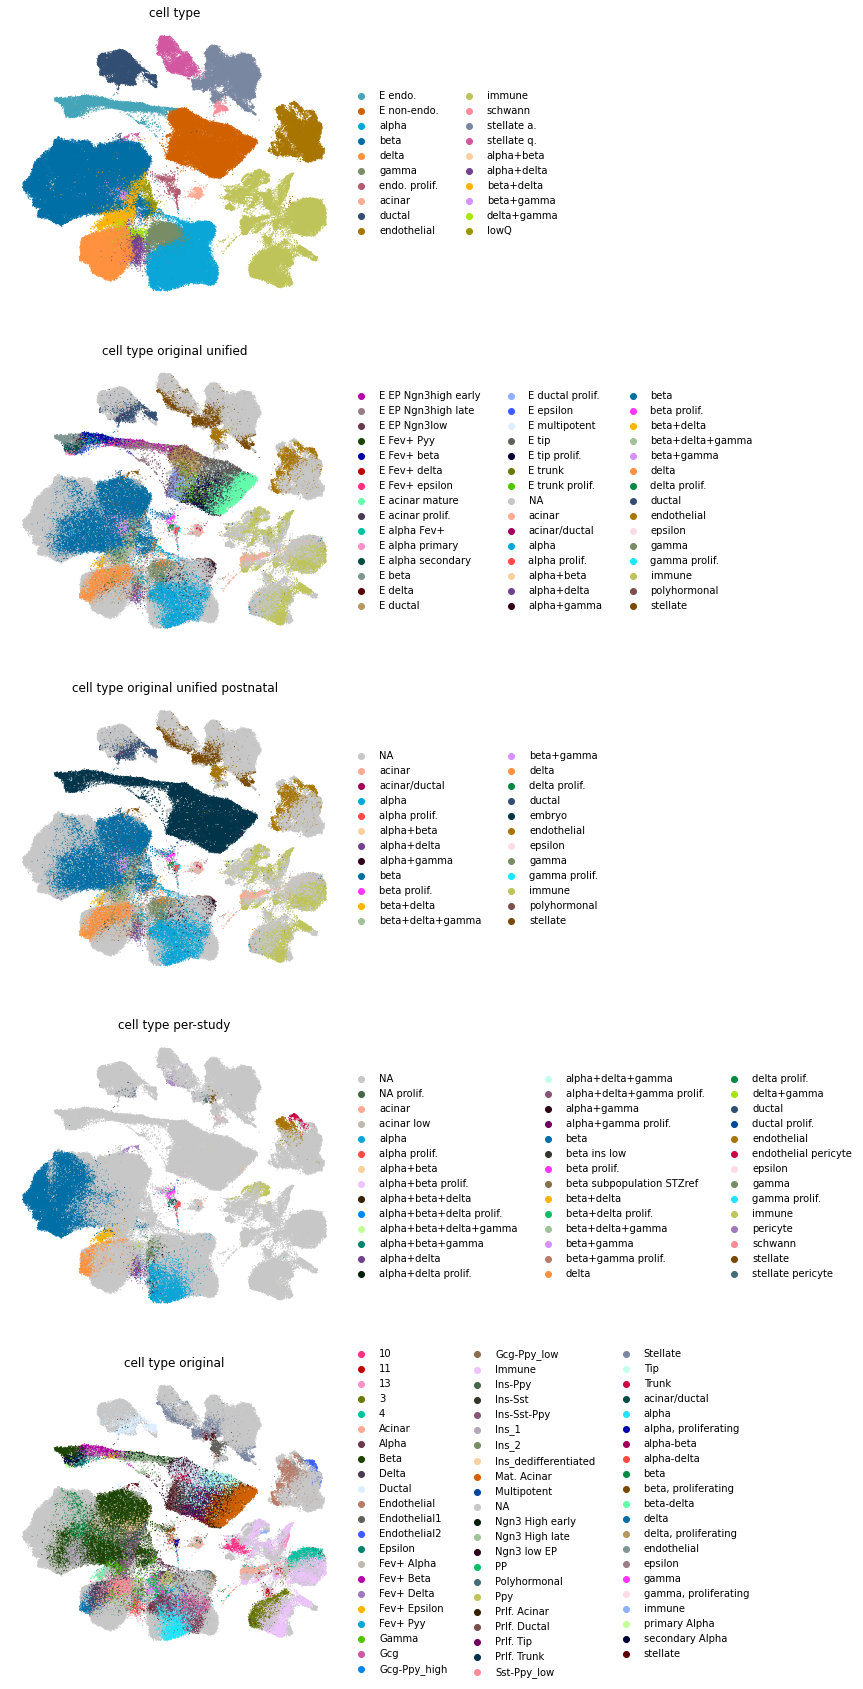

In [15]:
# Plot different cell types
cols=ct_cols+['pre_cell_type_original']
fig,ax=plt.subplots(len(cols),1,figsize=(6,6*len(cols)))
random_indices=np.random.permutation(list(range(adata.shape[0])))
for idx,(col,title) in enumerate(zip(cols,
                     ['cell type','cell type original unified',
                 'cell type original unified postnatal','cell type per-study',
                      'cell type original'])):
    sc.pl.umap(adata[random_indices,:],color=col, ncols=1,
               s=5,hspace=0.7,
              title=title,
              frameon=False, ax=ax[idx],show=False)
#fig.tight_layout()
plt.savefig(path_fig+'umap_atlas_celltypes.png',dpi=300,bbox_inches='tight')

Plot study info

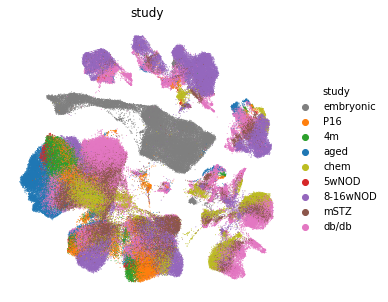

In [5]:
fig,ax=plt.subplots(figsize=(5,5))
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata.shape[0])))
sc.pl.umap(adata[random_indices,:],color='study_parsed',s=3,
          frameon=False,title='study',ax=ax,show=False)
#fig.tight_layout() # Set to False so that stuff is properly drawn
ax.legend_.set_title('study')
plt.savefig(path_fig+'umap_atlas_covariate_study.png',dpi=300,bbox_inches='tight')

#### Plots without lowQ - low quality populations on atlas and low quality cells from individual subtypes. 
NOTE: This part needs to be done after generating beta cell, immune, and alpha anootation.

In [5]:
# Remove low q/doublet
subset=~(adata.obs.cell_type_integrated_v1_parsed.str.contains("\+").values | 
         adata.obs.cell_type_integrated_v1_parsed.str.contains("lowQ").values)
print(subset.sum(),subset.shape)

290977 (301796,)


In [6]:
# Get also lowQ from alpha and beta
alpha_lowq=sc.read(path_data+'data_rawnorm_integrated_analysed_alpha.h5ad',
                   backed='r').obs.query('low_quality').index.copy()
beta_lowq=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
                  backed='r').obs.query('`leiden_r1.5_parsed_const`.str.contains("low_quality")',
                             engine='python').index.copy()
# Update subset of cells to be used
subset=pd.Series(subset,index=adata.obs_names)
subset.loc[alpha_lowq]=False
subset.loc[beta_lowq]=False
print(subset.sum())

287818


In [ ]:
# Save lowq assignment
adata.obs['low_q']=subset
if True:
    h.update_adata(adata_new=adata,path=path_data+'data_integrated_analysed.h5ad',
               add=[
                  ('obs',True,'low_q','low_q'),
               ],
               rm=None,unique_id2=None,io_copy=False)

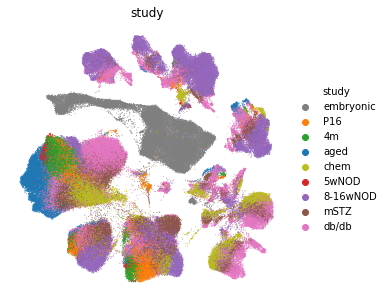

In [15]:
fig,ax=plt.subplots(figsize=(5,5))
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata[adata.obs['low_q'],:].shape[0])))
sc.pl.umap(adata[adata.obs['low_q'],:][random_indices,:],color='study_parsed',s=3,
          frameon=False,title='study',ax=ax,show=False)
#fig.tight_layout() # Set to False so that stuff is properly drawn
ax.legend_.set_title('study')
plt.savefig(path_fig+'umap_atlas_covariate_study_nolowQ.png',dpi=300,bbox_inches='tight')

Trying to set attribute `.uns` of view, copying.


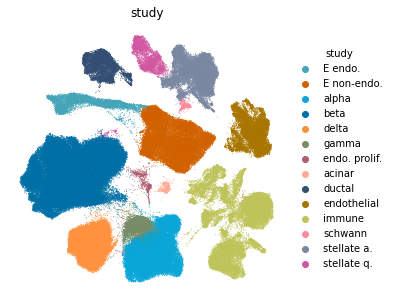

In [12]:
# Ct
fig,ax=plt.subplots(figsize=(5,5))
np.random.seed(0)
cl_cmap=dict(zip(adata.obs['cell_type_integrated_v2'].cat.categories,
                 adata.uns['cell_type_integrated_v2_colors']))
cl_cmap={ct:cl_cmap[adata.obs.query('cell_type_integrated_v2_parsed==@ct'
                        )['cell_type_integrated_v2'].values[0]] 
         for ct in adata.obs['cell_type_integrated_v2_parsed'].cat.categories}
random_indices=np.random.permutation(list(range(adata[adata.obs['low_q'],:].shape[0])))
sc.pl.umap(adata[adata.obs['low_q'],:][random_indices,:],
           color='cell_type_integrated_v2_parsed',s=3,
          frameon=False,title='study',ax=ax,show=False,palette=cl_cmap)
#fig.tight_layout() # Set to False so that stuff is properly drawn
ax.legend_.set_title('study')
plt.savefig(path_fig+'umap_atlas_celltype_integrated_nolowQ.png',
            dpi=300,bbox_inches='tight')

#### Compare cell type overlaps per study

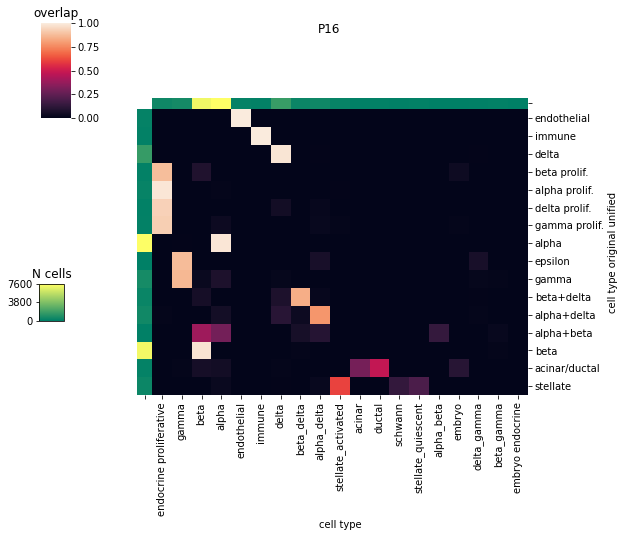

alpha            7522
beta             7226
delta            1607
NA                724
gamma             673
alpha+delta       507
stellate          384
beta+delta        307
alpha prolif.     213
endothelial       174
acinar/ductal     127
beta prolif.      108
gamma prolif.      92
immune             90
delta prolif.      60
alpha+beta         51
epsilon            16
Name: pre_cell_type_unified, dtype: int64

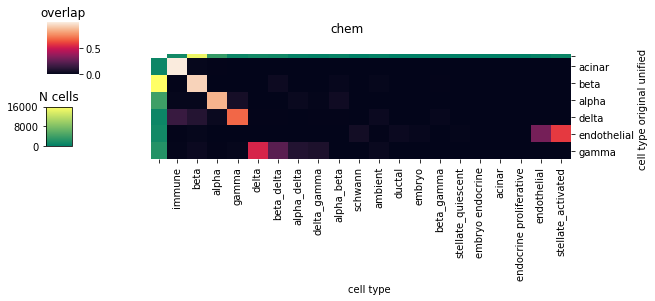

beta           15948
NA              8462
alpha           3897
gamma           2267
endothelial     1137
acinar           845
delta            775
Name: pre_cell_type_unified, dtype: int64

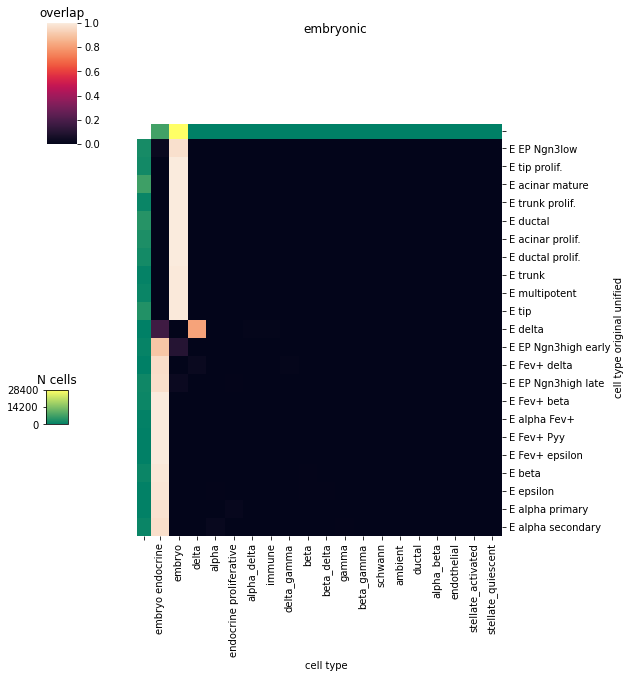

E acinar mature        6972
E ductal               4262
E tip                  3796
E acinar prolif.       3289
E EP Ngn3low           2582
E ductal prolif.       2298
E tip prolif.          2193
E EP Ngn3high late     1726
NA                     1641
E Fev+ beta            1359
E beta                 1232
E trunk prolif.        1188
E multipotent          1187
E alpha secondary      1159
E EP Ngn3high early     767
E trunk                 615
E alpha Fev+            345
E alpha primary         263
E epsilon               230
E Fev+ Pyy              132
E Fev+ epsilon          112
E Fev+ delta            110
E delta                 103
Name: pre_cell_type_unified, dtype: int64

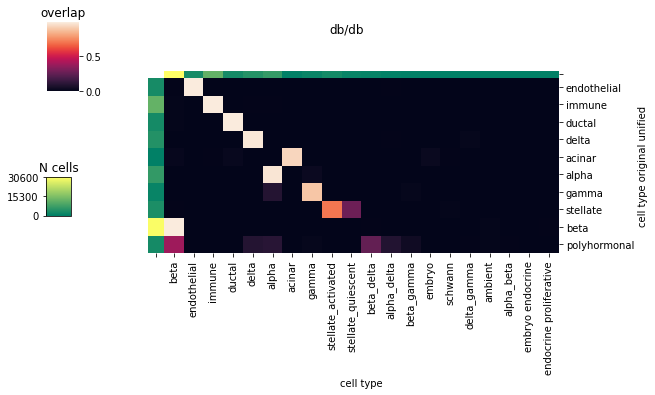

beta            30000
immune          12061
alpha            6211
NA               4472
delta            4242
stellate         3449
endothelial      2853
polyhormonal     2606
ductal           2592
gamma            1024
acinar            235
Name: pre_cell_type_unified, dtype: int64

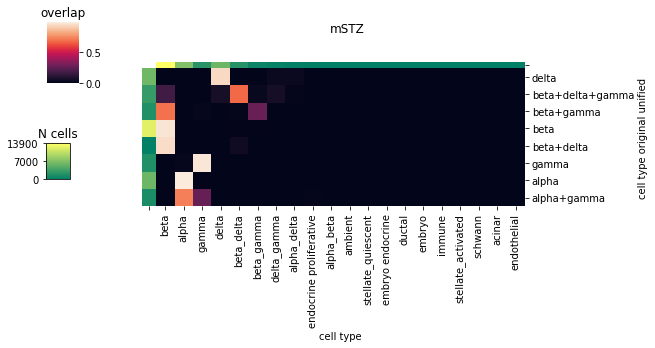

NA                  17101
beta                12262
delta                6110
alpha                5963
beta+delta+gamma     2951
beta+gamma           1788
gamma                1762
alpha+gamma          1486
beta+delta            122
Name: pre_cell_type_unified, dtype: int64

In [13]:
# Per study comparison of previous and my annotation, using unified annotation
for study in adata.obs.study_parsed.unique():
    obs_sub=adata[adata.obs.study_parsed==study,:].obs
    if not (obs_sub['pre_cell_type_unified']=='NA').all():
        # Confusion matrix normalised by previous anno group
        # Do not display NA from previous anno (cells not present)
        confusion=obs_sub.groupby(['pre_cell_type_unified'],dropna=False)[
            'cell_type_integrated_v2'].value_counts(
            normalize=True,dropna=False).unstack().fillna(0).drop('NA',axis=0)
        confusion.columns.name='cell type'
        confusion.index.name='cell type original unified'
        
        # Colorscale
        # Min and max values
        confusion_unnorm=obs_sub.groupby(['pre_cell_type_unified'],dropna=False)[
            'cell_type_integrated_v2'].value_counts(
            dropna=False).unstack().fillna(0).drop('NA',axis=0)
        # Round scale to certain precision
        sums_rows=confusion_unnorm.sum(axis=1)
        sums_cols=confusion_unnorm.sum(axis=0)
        round_to=100
        min_n=math.floor(min(sums_cols.min(),sums_rows.min())/round_to)*round_to
        max_n=math.ceil(max(sums_cols.max(),sums_rows.max()) /round_to)*round_to        
        # Make colorscale colors
        normalize = mcolors.Normalize(vmin=min_n,  vmax=max_n)
        cmap=cm.summer
        col_colors=sums_cols.apply(lambda n:cmap(normalize(n))).rename(None)
        row_colors=sums_rows.apply(lambda n:cmap(normalize(n))).rename(None)

        # Heatmap
        figsize=[confusion.shape[1]/3+2,
                 confusion.shape[0]/3+2]
        g=sb.clustermap(confusion,
                        xticklabels=True,yticklabels=True,
                       figsize=figsize,
                        col_colors=col_colors,row_colors=row_colors)
        g.ax_cbar.set_title('overlap')   
        g.fig.suptitle(study)
        
        # Legend N cells
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
        ax=g.fig.add_subplot(223)
        cbar=plt.colorbar(scalarmappaple,location='left',
                     ticks=[
            min_n, math.ceil((max_n+min_n)/(round_to*2))*round_to,max_n],fraction=0.1,
                     pad=1.1,aspect=1.5)
        cbar.ax.set_title('N cells')
        ax.axis('off')
        
        #remove dendrogram
        g.ax_row_dendrogram.set_visible(False)
        g.ax_col_dendrogram.set_visible(False)
        
        display(g.fig)
        
        # Print N cells
        n_cells_previous=obs_sub['pre_cell_type_unified'].value_counts()
        display(n_cells_previous)
        
        plt.close()

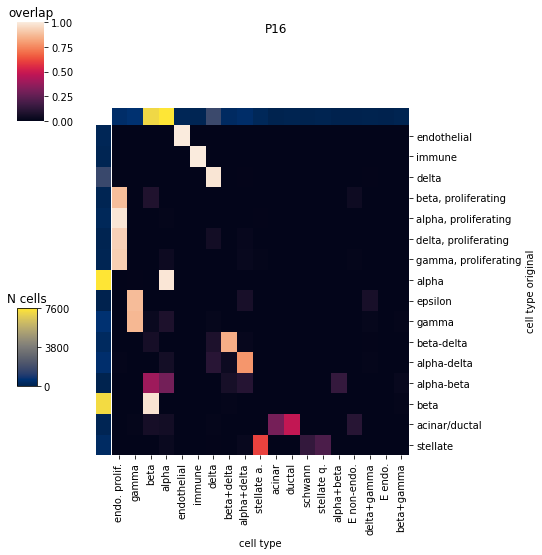

alpha            7522
beta             7226
delta            1607
NA                724
gamma             673
alpha+delta       507
stellate          384
beta+delta        307
alpha prolif.     213
endothelial       174
acinar/ductal     127
beta prolif.      108
gamma prolif.      92
immune             90
delta prolif.      60
alpha+beta         51
epsilon            16
Name: pre_cell_type_unified, dtype: int64

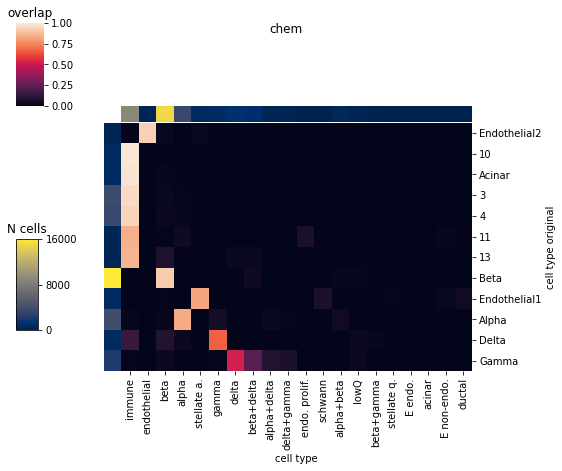

beta           15948
NA              8462
alpha           3897
gamma           2267
endothelial     1137
acinar           845
delta            775
Name: pre_cell_type_unified, dtype: int64

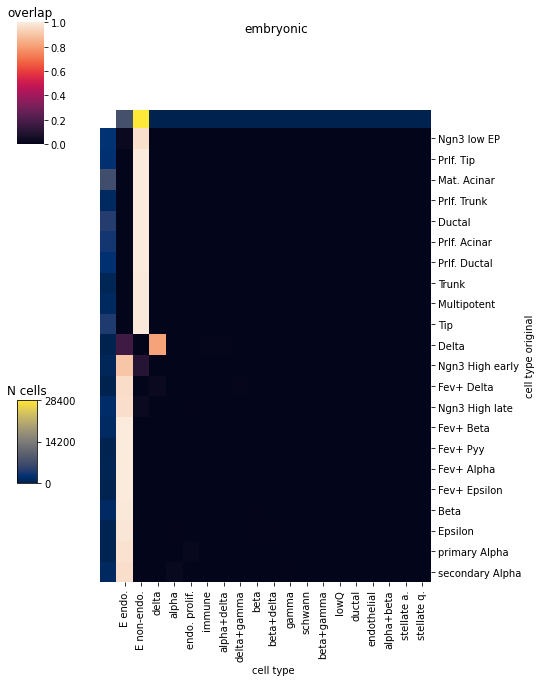

E acinar mature        6972
E ductal               4262
E tip                  3796
E acinar prolif.       3289
E EP Ngn3low           2582
E ductal prolif.       2298
E tip prolif.          2193
E EP Ngn3high late     1726
NA                     1641
E Fev+ beta            1359
E beta                 1232
E trunk prolif.        1188
E multipotent          1187
E alpha secondary      1159
E EP Ngn3high early     767
E trunk                 615
E alpha Fev+            345
E alpha primary         263
E epsilon               230
E Fev+ Pyy              132
E Fev+ epsilon          112
E Fev+ delta            110
E delta                 103
Name: pre_cell_type_unified, dtype: int64

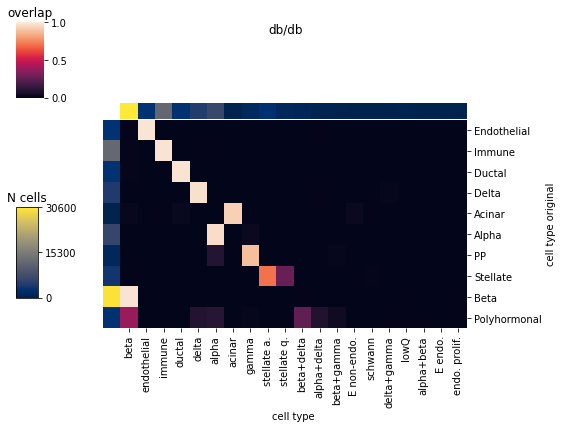

beta            30000
immune          12061
alpha            6211
NA               4472
delta            4242
stellate         3449
endothelial      2853
polyhormonal     2606
ductal           2592
gamma            1024
acinar            235
Name: pre_cell_type_unified, dtype: int64

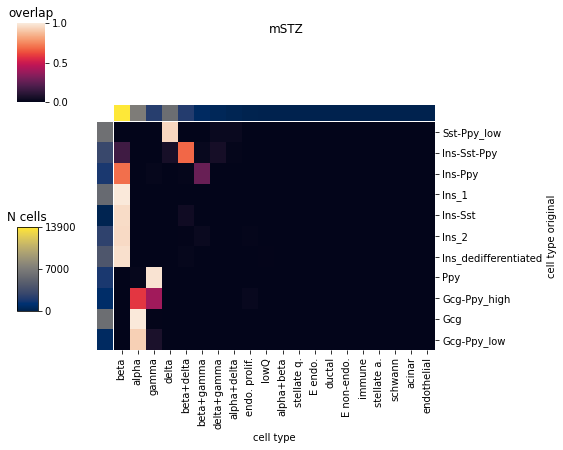

NA                  17101
beta                12262
delta                6110
alpha                5963
beta+delta+gamma     2951
beta+gamma           1788
gamma                1762
alpha+gamma          1486
beta+delta            122
Name: pre_cell_type_unified, dtype: int64

In [14]:
# Per study comparison of previous and my annotation (not unified)
for study in adata.obs.study_parsed.unique():
    obs_sub=adata[adata.obs.study_parsed==study,:].obs
    if not (obs_sub['pre_cell_type_original']=='NA').all():
        # Confusion matrix normalised by previous anno group
        # Do not display NA from previous anno (cells not present)
        confusion=obs_sub.groupby(['pre_cell_type_original'],dropna=False)[
            'cell_type_integrated_v2_parsed'].value_counts(
            normalize=True,dropna=False).unstack().fillna(0).drop('NA',axis=0)
        confusion.columns.name='cell type'
        confusion.index.name='cell type original'
        
        # Colorscale
        # Min and max values
        confusion_unnorm=obs_sub.groupby(['pre_cell_type_original'],dropna=False)[
            'cell_type_integrated_v2_parsed'].value_counts(
            dropna=False).unstack().fillna(0).drop('NA',axis=0)
        # Round scale to certain precision
        sums_rows=confusion_unnorm.sum(axis=1)
        sums_cols=confusion_unnorm.sum(axis=0)
        round_to=100
        min_n=math.floor(min(sums_cols.min(),sums_rows.min())/round_to)*round_to
        max_n=math.ceil(max(sums_cols.max(),sums_rows.max()) /round_to)*round_to        
        # Make colorscale colors
        normalize = mcolors.Normalize(vmin=min_n,  vmax=max_n)
        cmap=cm.cividis
        col_colors=sums_cols.apply(lambda n:cmap(normalize(n))).rename(None)
        row_colors=sums_rows.apply(lambda n:cmap(normalize(n))).rename(None)

        # Heatmap
        w_dend=1.5
        w_colors=0.3
        nrow=confusion.shape[0]*0.3+1
        ncol=confusion.shape[1]*0.3
        w=ncol+w_colors+w_dend
        h=nrow+w_colors+w_dend
        g=sb.clustermap(confusion,
                        xticklabels=True,yticklabels=True,
                       figsize=(w,h),
                        colors_ratio=(w_colors/w,1.02*w_colors/h),
                        dendrogram_ratio=(w_dend/w,w_dend/h),
                        col_colors=col_colors,row_colors=row_colors,
                       vmin=0,vmax=1)
        g.ax_cbar.set_title('overlap')   
        g.fig.suptitle(study)
        
        # Legend N cells
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
        ax=g.fig.add_subplot(223)
        cbar=plt.colorbar(scalarmappaple,location='left',
                     ticks=[
            min_n, math.ceil((max_n+min_n)/(round_to*2))*round_to,max_n],fraction=0.1,
                     pad=1.1,aspect=4)
        cbar.ax.set_title('N cells')
        cbar.ax.yaxis.set_ticks_position('right')
        ax.axis('off')
        
        #remove dendrogram
        g.ax_row_dendrogram.set_visible(False)
        g.ax_col_dendrogram.set_visible(False)
        
        # remove color ticks
        g.ax_row_colors.tick_params(axis='both', which='both', length=0)
        g.ax_col_colors.tick_params(axis='both', which='both', length=0)
        
        display(g.fig)
        plt.savefig(path_fig+'heatmap_atlas_celltype_pre_comparison_'+study.replace('/','')+'.png',
                    dpi=300,bbox_inches='tight')
        
        # Print N cells
        n_cells_previous=obs_sub['pre_cell_type_unified'].value_counts()
        display(n_cells_previous)
        
        plt.close()

Comparison of my ref per study annotation and integrated annotation

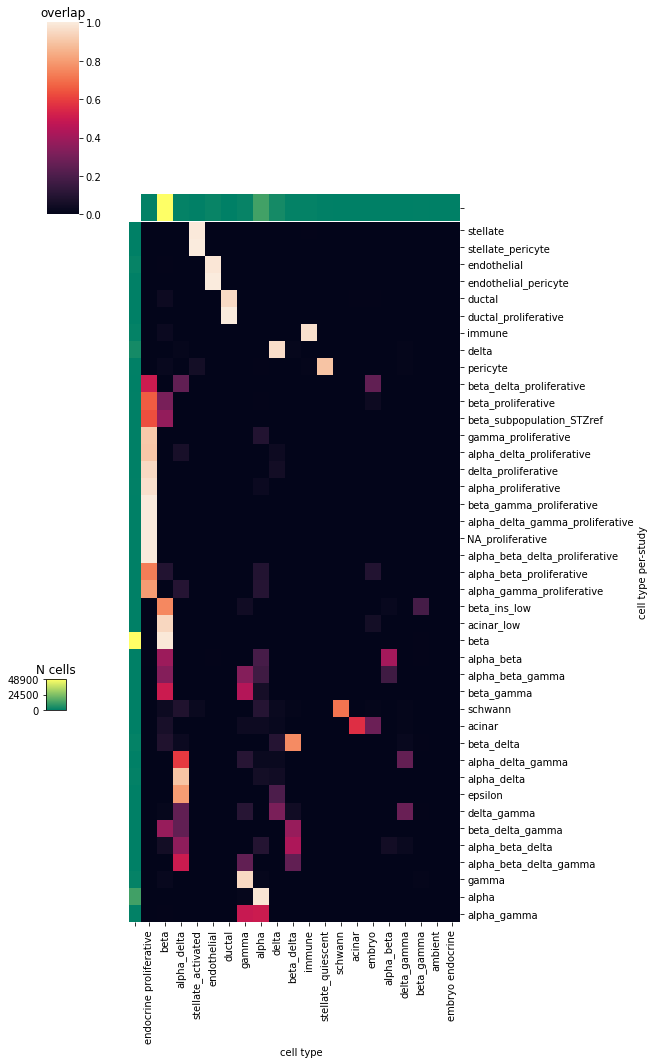

NA                     124133
beta                    65436
alpha                   23593
delta                   12734
immune                  12151
E acinar mature          6972
gamma                    5726
E ductal                 4262
endothelial              4164
stellate                 3833
E tip                    3796
E acinar prolif.         3289
beta+delta+gamma         2951
polyhormonal             2606
ductal                   2592
E EP Ngn3low             2582
E ductal prolif.         2298
E tip prolif.            2193
beta+gamma               1788
E EP Ngn3high late       1726
alpha+gamma              1486
E Fev+ beta              1359
E beta                   1232
E trunk prolif.          1188
E multipotent            1187
E alpha secondary        1159
acinar                   1080
E EP Ngn3high early       767
E trunk                   615
alpha+delta               507
beta+delta                429
E alpha Fev+              345
E alpha primary           263
E epsilon 

In [15]:
# Per study comparison of previous and my annotation (not unified)
obs_sub=adata.obs
# Confusion matrix normalised by previous anno group
# Do not display NA from previous anno (cells not present)
# Drop NA (missing) cells in comparison ct set
confusion=obs_sub.groupby(['cell_type'],dropna=False)[
    'cell_type_integrated_v2'].value_counts(
    normalize=True,dropna=False).unstack().fillna(0).drop('NA',axis=0)
confusion.columns.name='cell type'
confusion.index.name='cell type per-study'

# Colorscale
# Min and max values
confusion_unnorm=obs_sub.groupby(['cell_type'],dropna=False)[
    'cell_type_integrated_v2'].value_counts(
    dropna=False).unstack().fillna(0).drop('NA',axis=0)
# Round scale to certain precision
sums_rows=confusion_unnorm.sum(axis=1)
sums_cols=confusion_unnorm.sum(axis=0)
round_to=100
min_n=math.floor(min(sums_cols.min(),sums_rows.min())/round_to)*round_to
max_n=math.ceil(max(sums_cols.max(),sums_rows.max()) /round_to)*round_to        
# Make colorscale colors
normalize = mcolors.Normalize(vmin=min_n,  vmax=max_n)
cmap=cm.summer
col_colors=sums_cols.apply(lambda n:cmap(normalize(n))).rename(None)
row_colors=sums_rows.apply(lambda n:cmap(normalize(n))).rename(None)

# Heatmap
figsize=[confusion.shape[1]/3+2,
         confusion.shape[0]/3.2+2]
g=sb.clustermap(confusion,
                xticklabels=True,yticklabels=True,
               figsize=figsize,
                col_colors=col_colors,row_colors=row_colors)
g.ax_cbar.set_title('overlap')   

# Legend N cells
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
ax=g.fig.add_subplot(223)
cbar=plt.colorbar(scalarmappaple,location='left',
             ticks=[
    min_n, math.ceil((max_n+min_n)/(round_to*2))*round_to,max_n],fraction=0.1,
             pad=1.1,aspect=1.5)
cbar.ax.set_title('N cells')
ax.axis('off')

#remove dendrogram
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

display(g.fig)
plt.savefig(path_fig+'heatmap_atlas_celltype_refperstudy_comparison.png',
            dpi=300,bbox_inches='tight')

# Print N cells
n_cells_previous=obs_sub['pre_cell_type_unified'].value_counts()
display(n_cells_previous)

plt.close()

C: 
- We did not resolve endocrine proliferative clusters, although they are clearly visible in the UMAP.
- Could not resolve epsilon cells as too little of them. They did not form a separate cluster (close to gamma cells).
- Some doublet annotations differ, but these are hard anyways. Also for gamma cells it is sometimes hard to figure out if gamma doublets or just Ppy expression as other cts also express it.
- Annotated some non-endocrine cell types not annotated in other studies (e.g. schwann, stellate subtypes,...)
- Spikein drug has many wrong anno from original study - some of it was corrected in paper but not GEO. 
- Interestingly, embryo delta cells map to postnatal delta cells.